# Gaussian Process on the Wiggle dataset
## Exact inference

# Github

In [1]:
from google.colab import drive # For github
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Project18/GPs
!git config --global user.email "alexander.sabelstrom.1040@student.uu.se"
!git config --global user.name "Sabelz"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Project18/GPs


# Imports

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


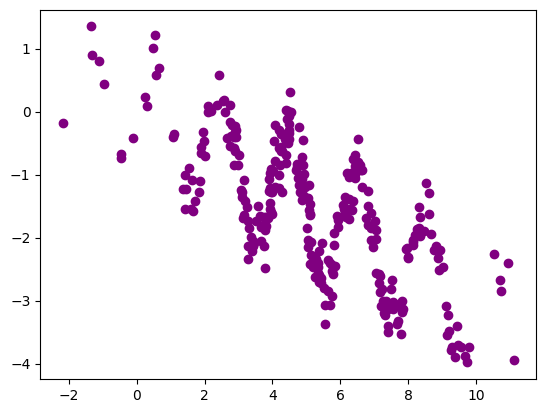

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import torch
#!pip install gpytorch
import gpytorch

%matplotlib inline
%load_ext autoreload
%autoreload 2
%run ../datasets/wiggle.ipynb # Run the wiggle notebook which is in the same folder(Wiggle dataset)


# Training Data from wiggle

In [33]:
xTrain, yTrain = x, samples # x, samples are defined in ../datasets/wiggle.ipynb
xTrain, yTrain = torch.from_numpy(xTrain), torch.from_numpy(yTrain) # Convert them to tensors

# The GP model

In [34]:
# Class for the GP model(Exact GP)
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() # Decide which mean to use
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # Decide which kernel to use
    # GP Posterior predictive distribution
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the first model

In [35]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
model = GPModel(xTrain, yTrain, likelihood) # For the first example, RBF kernel is used

# Train the Model

In [36]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(xTrain)
    # Calc loss and backprop gradients
    loss = -mll(output, yTrain)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.987   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.943   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.903   lengthscale: 0.602   noise: 0.598
Iter 4/50 - Loss: 0.866   lengthscale: 0.570   noise: 0.554
Iter 5/50 - Loss: 0.831   lengthscale: 0.551   noise: 0.513
Iter 6/50 - Loss: 0.796   lengthscale: 0.543   noise: 0.474
Iter 7/50 - Loss: 0.761   lengthscale: 0.544   noise: 0.437
Iter 8/50 - Loss: 0.727   lengthscale: 0.552   noise: 0.403
Iter 9/50 - Loss: 0.693   lengthscale: 0.566   noise: 0.371
Iter 10/50 - Loss: 0.660   lengthscale: 0.583   noise: 0.341
Iter 11/50 - Loss: 0.628   lengthscale: 0.602   noise: 0.313
Iter 12/50 - Loss: 0.598   lengthscale: 0.622   noise: 0.287
Iter 13/50 - Loss: 0.568   lengthscale: 0.641   noise: 0.263
Iter 14/50 - Loss: 0.540   lengthscale: 0.657   noise: 0.241
Iter 15/50 - Loss: 0.513   lengthscale: 0.667   noise: 0.220
Iter 16/50 - Loss: 0.488   lengthscale: 0.672   noise: 0.202
Iter 17/50 - Loss: 0.463   length

# Test Data

In [45]:
# Observing the plot of the wiggle dataset, x varies between -1-12
xTest = torch.linspace(-3, 15, 50)

# The posterior mean, variance and Covariance Matrix

In [46]:
model.eval() # eval mode is for computing predictions through the model posterior
f_preds = model(xTest) # returns the model posterior distribution p(f* | x*, X, y), for training data X, y
f_mean = f_preds.mean # Predictive mean
f_var = f_preds.variance # Predictive variance
f_covar = f_preds.covariance_matrix # Covariance matrix
print("Mean Dimension: ", f_mean.size())
print()
print("Variance Dimension: ", f_var.size())
print()
print("CovMatrix Dimension ", f_covar.size())

Mean Dimension:  torch.Size([50])

Variance Dimension:  torch.Size([50])

CovMatrix Dimension  torch.Size([50, 50])


# Plots of samples from the GP

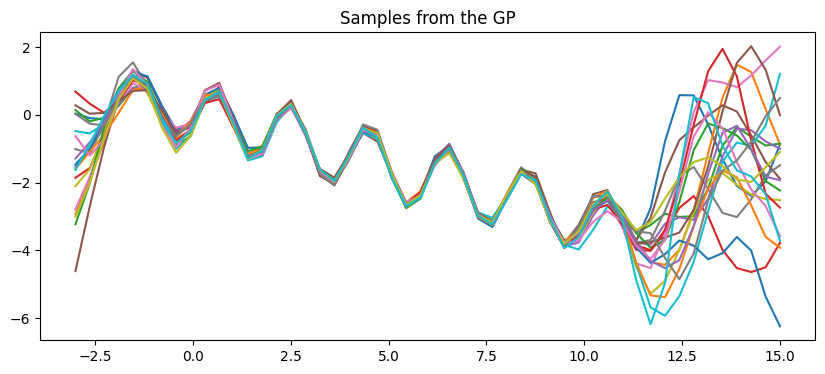

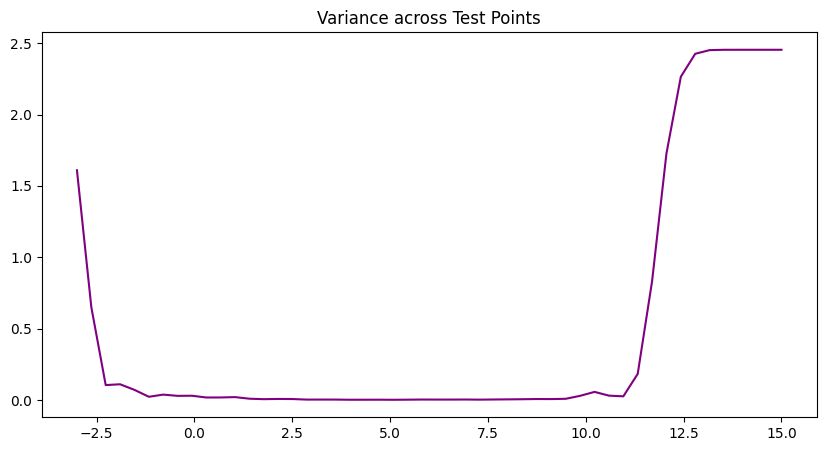

In [63]:
# Convert to numpy
xTestPlot = xTest.detach().numpy()
f_meanPlot = f_mean.detach().numpy()
f_varPlot = f_var.detach().numpy()
# Plot samples from the GP
plt.figure(figsize=(10, 4))
for i in range(20):  # Generate 20 samples
    f_sample = f_preds.sample().detach().numpy()
    plt.plot(xTestPlot, f_sample)
plt.title('Samples from the GP')
plt.show()
# Plot variance
plt.figure(figsize=(10, 5))
plt.plot(xTestPlot, f_varPlot, 'purple')
plt.title('Variance across Test Points')
plt.show()

# Predictive Distribution

In [65]:
model.eval() # eval mode is for computing predictions through the model posterior.
likelihood.eval()



# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
    observed_pred = likelihood(model(xTest))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value

# Plot with RBF kernel

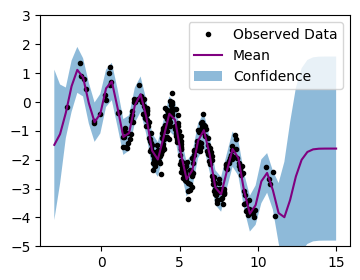

In [66]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(xTrain.numpy(), yTrain.numpy(), 'k.')
    # Plot predictive means as purple line
    ax.plot(xTest.numpy(), observed_pred.mean.numpy(), 'purple')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(xTest.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-5, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

# GP with a periodic+RBF kernel instead

In [100]:
# Class for the GP model(Exact GP)
class GPModelPeriodic(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModelPeriodic, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() # Decide which mean to use
        # This kernel adds the RBF kernel with a Periodic kernel
        self.rbf_kernel = gpytorch.kernels.RBFKernel()
        self.periodic_kernel = gpytorch.kernels.PeriodicKernel()
        self.covar_module = gpytorch.kernels.ScaleKernel(self.rbf_kernel + self.periodic_kernel)
    # GP Posterior predictive distribution
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood2 = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
modelPeriodic = GPModelPeriodic(xTrain, yTrain, likelihood2) # Now kernel is changed to periodic
# Set the hyperparameters for the Periodic Kernel
modelPeriodic.periodic_kernel.period_length = 3 # Set initial period length to 6
modelPeriodic.periodic_kernel.period_length.fixed = False # Make sure it is not fixed during training


# Train the periodic model

In [101]:
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 40

# Find optimal model hyperparameters
modelPeriodic.train()
likelihood2.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(modelPeriodic.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters


mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood2, modelPeriodic) # Decide loss


for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = modelPeriodic(xTrain)
    # Calc loss and backprop gradients
    loss = -mll(output, xTrain)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   RBF lengthscale: %.3f   Periodic lengthscale: %.3f   noise: %.3f  periodLength: %.3f'  % (
    i + 1, training_iter, loss.item(),
    modelPeriodic.rbf_kernel.lengthscale.item(),
    modelPeriodic.periodic_kernel.lengthscale.item(),
    modelPeriodic.likelihood.noise.item(),
    modelPeriodic.periodic_kernel.period_length.item()
))
    optimizer.step()

Iter 1/40 - Loss: 1.227   RBF lengthscale: 0.693   Periodic lengthscale: 0.693   noise: 0.693  periodLength: 3.000
Iter 2/40 - Loss: 1.147   RBF lengthscale: 0.744   Periodic lengthscale: 0.744   noise: 0.644  periodLength: 2.905
Iter 3/40 - Loss: 1.074   RBF lengthscale: 0.798   Periodic lengthscale: 0.798   noise: 0.598  periodLength: 2.822
Iter 4/40 - Loss: 1.005   RBF lengthscale: 0.853   Periodic lengthscale: 0.853   noise: 0.554  periodLength: 2.817
Iter 5/40 - Loss: 0.938   RBF lengthscale: 0.910   Periodic lengthscale: 0.910   noise: 0.513  periodLength: 2.846
Iter 6/40 - Loss: 0.875   RBF lengthscale: 0.969   Periodic lengthscale: 0.968   noise: 0.474  periodLength: 2.896
Iter 7/40 - Loss: 0.814   RBF lengthscale: 1.029   Periodic lengthscale: 1.027   noise: 0.437  periodLength: 2.955
Iter 8/40 - Loss: 0.756   RBF lengthscale: 1.090   Periodic lengthscale: 1.086   noise: 0.402  periodLength: 3.013
Iter 9/40 - Loss: 0.700   RBF lengthscale: 1.151   Periodic lengthscale: 1.147  

# The posterior mean, variance and Covariance Matrix

In [97]:
modelPeriodic.eval() # eval mode is for computing predictions through the model posterior
f_preds2 = modelPeriodic(xTest) # returns the model posterior distribution p(f* | x*, X, y), for training data X, y

f_mean2 = f_preds2.mean # Predictive mean
f_var2 = f_preds2.variance # Predictive variance
f_covar2 = f_preds2.covariance_matrix # Covariance matrix
print("Mean Dimension: ", f_mean2.size())
print()
print("Variance Dimension: ", f_var2.size())
print()
print("CovMatrix Dimension ", f_covar2.size())

Mean Dimension:  torch.Size([50])

Variance Dimension:  torch.Size([50])

CovMatrix Dimension  torch.Size([50, 50])


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


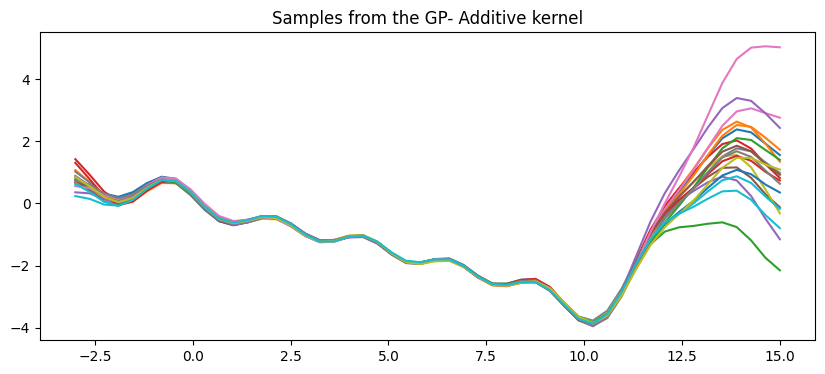

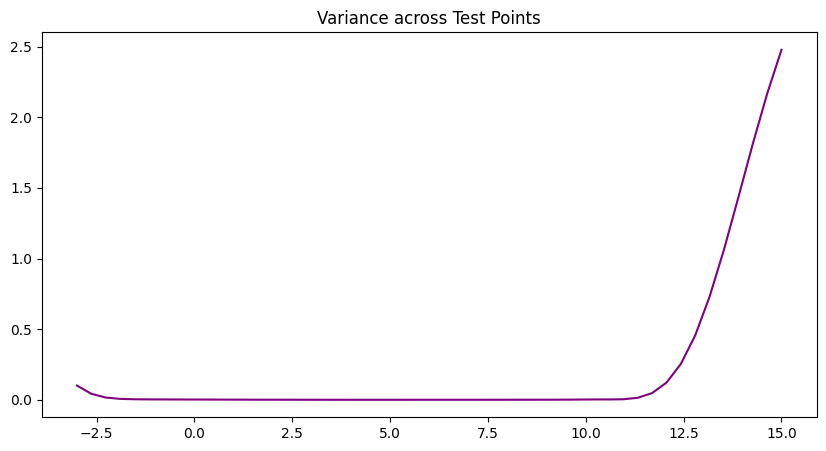

In [104]:
# Convert to numpy
xTestPlot = xTest.detach().numpy()
f_meanPlot2 = f_mean2.detach().numpy()
f_varPlot2 = f_var2.detach().numpy()
# Plot samples from the GP
plt.figure(figsize=(10, 4))
for i in range(20):  # Generate 20 samples
    f_sample = f_preds2.sample().detach().numpy()
    plt.plot(xTestPlot, f_sample)
plt.title('Samples from the GP- Additive kernel')
plt.show()
# Plot variance
plt.figure(figsize=(10, 5))
plt.plot(xTestPlot, f_varPlot2, 'purple')
plt.title('Variance across Test Points')
plt.show()

# Predictive Distribution

In [105]:
modelPeriodic.eval() # eval mode is for computing predictions through the model posterior.
likelihood2.eval()
y_preds2 = likelihood2(modelPeriodic(xTest)) # gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
    observed_pred2 = y_preds2 # ---

# Plot the periodic GP

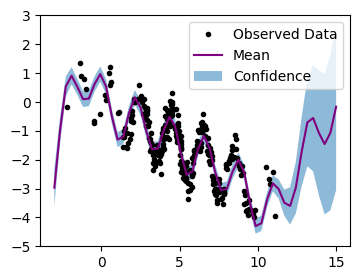

In [106]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred2.confidence_region()
    # Plot training data as black stars
    ax.plot(xTrain.numpy(), yTrain.numpy(), 'k.')
    # Plot predictive means as blue line
    ax.plot(xTest.numpy(), observed_pred2.mean.numpy(), 'purple')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(xTest.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-5, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [114]:
!git push

Enumerating objects: 8, done.
Counting objects: 100% (8/8), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 361.95 KiB | 8.62 MiB/s, done.
Total 5 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/Sabelz/Project18.git
   c91bea1..e136027  main -> main
